In [4]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

심층 신경망을 훈련할 때 발생할 수 있는 문제들
* *그레디언트 손실 또는 폭주* 문제 - 심층 신경망의 아래쪽으로 갈수록 그레디언트가 점점 작아지거나 커지는 현상
* 대규모 신경망을 위한 훈련 데이터가 충분하지 않거나 레이블을 만드는 작업에 비해 비용이 너무 많이 듬
* 훈련이 극단적으로 느려질 수 있음
* 수백만 개의 파라미터를 가진 모델은 훈련 세트에 과대적합될 위험이 매우 큼

참고하면 좋은 것 : https://www.slideshare.net/yongho/ss-79607172

# 1. 그레디언트 소실과 폭주 문제

역전파 알고리즘을 통해 모든 파라미터에 대해 오차 함수의 그레디언트를 계산하면 경사 하강법 단계에서 이 그레디언트를 사용하여 각 파라미러틑 수정한다. 그런데 알고리즘이 하위층으로 진행될수록 그레디언트가 점점 작아지는 경우가 발생한다. 이 문제를 **Vanishing Gradient**라고 한다.

In [5]:
def logit(z):
    return 1 / (1 + np.exp(-z))

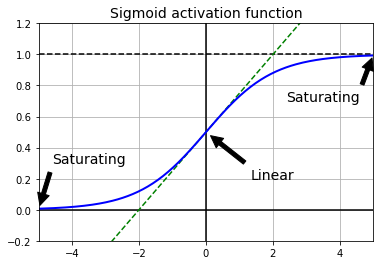

In [7]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

이러한 문제의 원인은, 많이 사용되는 로지스틱 시그모이드 활성화함수와 그 당시 가장 인기 있던 가중치 초기화 방법(평균이 0이고 표준편차가 1인 정규분포)의 조합이었다. 이 활성화 함수와 초기화 방법을 사용했을 때 각 층에서 출력의 분산이 입력의 분산보다 더 크다는 것을 밝혀냈다. 신경망의 위쪽으로 갈수록 층을 지날 때마다 분산이 계속 커져 가장 높은 층에서는 활성화함수가 0이나 1로 수렴한다. 이는 로지스틱 함수의 평균이 0이 아니고 0.5라는 사실 때문에 더 나빠진다.

로지스틱 활성화 함수를 보면 입력이 (양수나 음수로) 커지면 0이나 1로 수렴해서 기울기가 0에 매우 가까워지는 것을 알 수 있다. 그래서 역전파가 될 때 사실상 신경망으로 전파할 그레디언트가 거의 없고 조금 있는 그레디언트는 최상위층에서부터 역전파가 진행되면서 점차 약해져서 실쩨로 아래쪽 층에는 아무 것도 도달하지 않게 된다.

## 1.1 글로럿과 He 초기화

예측할 때는 정방향으로, 그레디언트를 역전파할 때는 역방향으로 양방향 신호가 적절하게 흘러야 한다. 저자들은 적절한 신호가 흐르기 위해서는 각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야 한다구 주장한다. 그리고 역방향에서 층을 통과하기 전과 후의 그레디언트 분산이 동일해야 한다.  
$$fan_{avg}=(fan_{in}+fan_{out})/2$$
* $fan_{in}$, $fan_{out}$ : 층의 입력과 출력 연결 갯수
  
이 초기화 전략을 저자의 이름을 따서 **세이비어 초기화(Xavier initialization) 또는 글로럿 초기화(Glorot initialization)** 라고 한다.

케라스는 기본적으로 균등분포의 글로럿 초기화를 사용한다.

In [ ]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal") #

## 1.2 수렴하지 않는 활성화 함수

활성화 함수를 잘못 선택하면 자칫 그레디언트의 소실이나 폭주로 이어질 수 있다. 그 전에는 sigmoid 활성화 함수가 최선의 선택으로 알려져 있었으나, ReLU 활성화 함수가 심층 신경망에서 훨씬 더 잘 작동한다는 사실이 밝혀졌다.

ReLU 또한 훈련하는 동안 일부 뉴런이 0 이외의 값을 출력하지 않는 dying ReLU 문제가 존재한다. 어떤 경우에는(특히 큰 학습률을 사용하면) 신경망의 뉴런 절반이 죽어있기도 하다.  
이 문제를 해결하기 위해 **LeakyReLU**같은 ReLU의 변종을 사용한다.
$$LeakyReLU_{\alpha}(z) = max(\alpha z, z)$$
* 하이퍼파라미터 $\alpha$ : 이 함수가 새는(leaky)정도를 결정
* 새는 정도란, z<0 일 때 이 함수의 기울기이며, 일반적으로 0.01로 설정
  
최근 논문에서는 여러 ReLU 함수의 변종을 비교해 얻은 결론 하나는 LeakyReLU가 ReLU보다 항상 성능이 높다는 것이다.

In [8]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

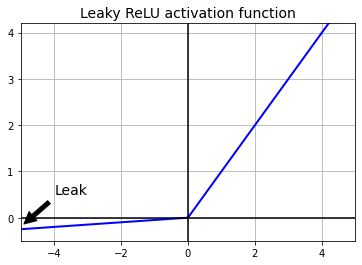

In [9]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

model = keras.models.Sequential(

In [ ]:
model = keras.models.Sequential([
    [...]
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.2),
    [...]
])

그 외에 **ELU(Exponential linear unit), SELU(Scaled ELU)** 등이 존재한다.

In [10]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

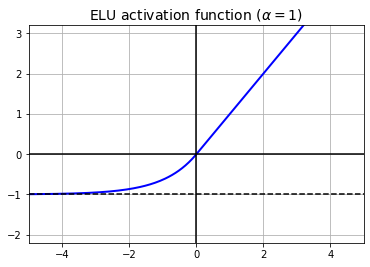

In [11]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [12]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화합니다
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [13]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

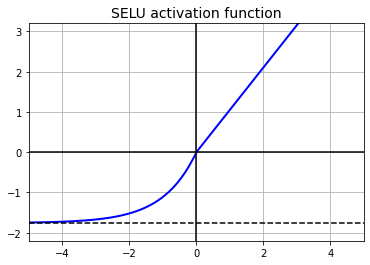

In [15]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [ ]:
keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal")

## 1.3 Batch Normalization

이 기법은 각 층에서 활성화 함수를 통과하기 전이나 후에 모델에 연산을 하나 추가한다. 이 연산은 단순하게 입력을 원점에 맞추고 정규화한 다음, 각 층에서 두 개의 새로운 파라미터로 결과값의 스케일을 조어하고 이동시킨다. 하나는 스케일 조정에, 다른 하나는 이동에 상요한다. 많은 경우 신경망의 첫 번째 층으로 배치 정규화를 추가하면 훈련 세트를 표준화할 필요가 없다. 배치 정규화 층이 이런 역할을 대신 한다.

$$\mu_B = \frac{1}{m_B}\sum_{i=1}^{m_B}x^{(i)}$$
$$\sigma_B^2=\frac{1}{m_B}\sum_{i=1}^{m_B}(x^{(i)}-\mu_B)^2$$
$$\hat{x}^{(i)}=\frac{x^{(i)}-\mu_B}{\sqrt{\sigma_B^2+\epsilon}}$$
$$z^{(i)}=\gamma \times \hat{x}^{(i)}+\beta$$
* $\mu_b$ : 미니배치 B에 대해 평가한 입력의 평균 벡터
* $\sigma_B$ : 미니배치 B에 대해 평가한 입력의 표준편차 벡터
* $m_B$ : 미니배치에 있는 샘플 수
* $\hat{x}^{(i)}$ : 평균이 0이고 정규화된 샘플 i의 입력
* $\gamma$ : 층의 출력 스케일 파라미터 벡터(입력마다 하나의 스케일 파라미터가 있음)
* $\times$ : 원소별 곱셈(element-wise multiplication)
* $\beta$ : 층의 출력 이동(오프셋) 파라미터 벡터, 각 입력은 해당 파라미터만큼 이동함
* $\epsilon$ : 분모가 0이 되는 것을 막히 위한 작은 숫자(smoothing term)
* $z^{(i)}$ : 배치 정규화 연산의 출력, 즉 입력의 스케일을 조정하고 이동시킨 것

In [17]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 30)                23550     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
batch_normalization_2 (Batch (None, 30)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3

## 1.4 Gradient Clipping

역전파될 때 일정 임곗값을 넘어서지 못하게 그레디언트를 잘라내는 방법이다. 순환 신경망은 배치 정규화를 적용하기 어려워서 이 방법을 많이 사용한다.

In [ ]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="mse", optimizer=optimizer)

이 옵티마이저는 그레디언트 벡터의 모든 원소를 -1.0과 1.0 사이로 클리핑한다. 즉 훈련되는 각 파라미터에 대한 손실의 모든 편미분 값을 -1.0에서 1.0으로 잘라낸다. 임계값은 하이퍼파라미터로 튜닝할 수 있다.